In [1]:
import seaborn as sns

In [44]:
import os
import json
from datetime import datetime

# Folder containing the JSON files
data_folder = 'data/'

# Create empty dictionary to store unique data by date
unique_data = {}

# Loop through all JSON files
for file_name in os.listdir(data_folder):
    if file_name.endswith(".json"):
        file_path = os.path.join(data_folder, file_name)

        # Read JSON data
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            results = data.get('results', [])

            for result in results:
                date_str = result.get('date', '') or result.get('dateObserved', '')
                if not date_str:
                    continue

                date = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S')
                value_data = result.get('value', {})

                # Extract temperature values
                if isinstance(value_data, dict):
                    tmax = value_data.get('value_tmax', value_data.get('valueMax', {}).get('value', None))
                    tmin = value_data.get('value_tmin', value_data.get('valueMin', {}).get('value', None))
                else:
                    # Handle case where 'value' is a float
                    tmax = value_data
                    tmin = value_data

                # Skip entries without temperature data
                if tmax is not None and tmin is not None:
                    # Add data to the dictionary
                    if date.strftime('%Y-%m-%d') not in unique_data:
                        unique_data[date.strftime('%Y-%m-%d')] = {
                            'Date': date.strftime('%Y-%m-%d'),
                            'TMAX': float('-inf'),  # Initialize with negative infinity
                            'TMIN': float('inf'),   # Initialize with positive infinity
                            'TAVG': []
                        }
                    unique_data[date.strftime('%Y-%m-%d')]['TMAX'] = max(unique_data[date.strftime('%Y-%m-%d')]['TMAX'], tmax)
                    unique_data[date.strftime('%Y-%m-%d')]['TMIN'] = min(unique_data[date.strftime('%Y-%m-%d')]['TMIN'], tmin)
                    unique_data[date.strftime('%Y-%m-%d')]['TAVG'].append((tmax + tmin) / 2)

# Calculate final TAVG for each date
for date_data in unique_data.values():
    date_data['TAVG'] = sum(date_data['TAVG']) / len(date_data['TAVG'])

# Sort data by date
sorted_dates = sorted(unique_data.keys())

# Write sorted data to CSV file
output_csv_path = os.path.join(data_folder, 'all_data_max_min_avg.csv')
with open(output_csv_path, 'w') as csv_file:
    # Write header
    csv_file.write("Date,TMAX,TMIN,TAVG\n")

    # Write data rows
    for date_str in sorted_dates:
        date_data = unique_data[date_str]
        csv_file.write(f"{date_data['Date']},{date_data['TMAX']},{date_data['TMIN']},{date_data['TAVG']}\n")

print(f"Combined data saved to {output_csv_path}")


Combined data saved to data/all_data_max_min_avg.csv


In [83]:
import os
import json
from dateutil import parser

# Function to extract the year from a filename
def extract_year(filename):
    return filename.split('_')[1].split('.')[0]

# Folder containing the JSON files
data_folder = 'data/'

# Dictionary to store the compiled data
compiled_data = {}

# Loop through all JSON files
for file_name in os.listdir(data_folder):
    if file_name.endswith('.json'):
        year = extract_year(file_name)

        # Read JSON data
        with open(os.path.join(data_folder, file_name), 'r') as json_file:
            data = json.load(json_file)
            results = data.get('results', [])

            # Extract relevant data and store it in the compiled_data dictionary
            for result in results:
                date_str = result.get('date', '') or result.get('dateObserved', '')
                if not date_str:
                    continue

                try:
                    date = parser.parse(date_str)
                except ValueError:
                    print(f"Skipping invalid date: {date_str}")
                    continue

                value_data = result.get('value', {})

                # Extract temperature values
                tavg = None
                if isinstance(value_data, (int, float)):
                    tavg = value_data
                elif isinstance(value_data, dict) and 'value' in value_data:
                    tavg = value_data['value']

                if tavg is not None:
                    date_key = date.strftime('%m-%d')
                    if date_key not in compiled_data:
                        compiled_data[date_key] = {}
                    compiled_data[date_key][year] = tavg

# Print problematic date strings
for date_key in compiled_data.keys():
    print(date_key, compiled_data[date_key])

# Sort dates in ascending order
sorted_dates = sorted(compiled_data.keys())

# Write data to CSV file
output_csv_path = os.path.join(data_folder, 'all_data_min.csv')
with open(output_csv_path, 'w') as csv_file:
    # Write header
    csv_file.write('Date,' + ','.join(sorted(compiled_data[sorted_dates[0]].keys())) + '\n')

    # Write data rows
    for date_key in sorted_dates:
        csv_file.write(date_key + ',')
        csv_file.write(','.join([str(compiled_data[date_key].get(year, '')) for year in sorted(compiled_data[date_key].keys())]) + '\n')

print(f"Compiled data saved to {output_csv_path}")


12-15 {'2015-2016': 1, '2019-2020': 1, '2021-2022': 1, '2010-2011': 1, '2022-2023': 32.0, '2012-2013': 1, '2013-2014': 0.0, '2018-2019': 25.1, '2020-2021': 1, '2014-2015': 1, '2016-2017': 25.1, '2008-2009': 1, '2017-2018': 25.1, '2011-2012': 23.0, '2009-2010': 23.9}
12-16 {'2015-2016': 21.9, '2019-2020': 1, '2021-2022': 21.9, '2010-2011': 23.0, '2022-2023': 36.9, '2012-2013': 1, '2013-2014': 0.0, '2018-2019': 21.0, '2020-2021': 23.9, '2014-2015': 16.1, '2016-2017': 1, '2008-2009': 1, '2017-2018': 23.0, '2011-2012': 17.0, '2009-2010': 21.9}
12-17 {'2015-2016': 1, '2019-2020': 25.9, '2021-2022': 33.1, '2010-2011': 1, '2022-2023': 23.9, '2012-2013': 40.9, '2013-2014': 0.0, '2018-2019': 16.1, '2020-2021': 25.1, '2014-2015': 1, '2016-2017': 1, '2008-2009': 19.9, '2017-2018': 1, '2011-2012': 12.1, '2009-2010': 25.1}
12-18 {'2015-2016': 21.0, '2019-2020': 25.9, '2021-2022': 15.0, '2010-2011': 1, '2022-2023': 23.9, '2012-2013': 1, '2013-2014': 0.0, '2018-2019': 21.0, '2020-2021': 1, '2014-2015

In [84]:
import pandas as pd

# Read the CSV file
weather_data = pd.read_csv('data/all_data_min.csv')

# Now you can use the weather_data DataFrame for further analysis

In [90]:
import pandas as pd

# Read the CSV file with parse_dates and date_format parameters
weather_data = pd.read_csv('data/all_data_min.csv', parse_dates=['Date'], date_format='%m-%d')

# Set 'Date' column as the index
weather_data.set_index('Date', inplace=True)

# Calculate the total average for all years
total_average = weather_data.mean().mean()

# Print the result
print(f"Total Average Temperature: {total_average:.2f}")


Total Average Temperature: 17.57


In [95]:
import pandas as pd

# Read the CSV file with explicit date format
weather_data = pd.read_csv('data/all_data_min.csv', parse_dates=['Date'], dayfirst=True, date_format='%m-%d')

def average_warmest(data_frame):
    # Calculate the maximum value for each year
    max_values = data_frame.drop('Date', axis=1).max(axis=1)

    # Calculate the seasonal average of the maximum values
    seasonal_avg_warmest = max_values.mean()

    return seasonal_avg_warmest

# Use the average_warmest function
average_warmest_value = average_warmest(weather_data)

# Print the result
print(f"Seasonal Average of the Warmest Temperatures: {average_warmest_value:.2f}")


Seasonal Average of the Warmest Temperatures: 42.74


In [97]:
import pandas as pd

# Read the CSV file with explicit date format
weather_data = pd.read_csv('data/all_data_min.csv', parse_dates=['Date'], dayfirst=True, date_format='%m-%d')

def average_coldest(data_frame):
    # Ensure numeric values for temperature columns
    data_frame.iloc[:, 1:] = data_frame.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

    # Calculate the minimum value for each year
    min_values = data_frame.drop('Date', axis=1).min(axis=1)

    # Calculate the seasonal average of the minimum values
    seasonal_avg_coldest = min_values.mean()

    return seasonal_avg_coldest

# Use the average_coldest function
average_coldest_value = average_coldest(weather_data)

# Print the result
print(f"Seasonal Average of the Coldest Temperatures: {average_coldest_value:.2f}")


Seasonal Average of the Coldest Temperatures: 0.63


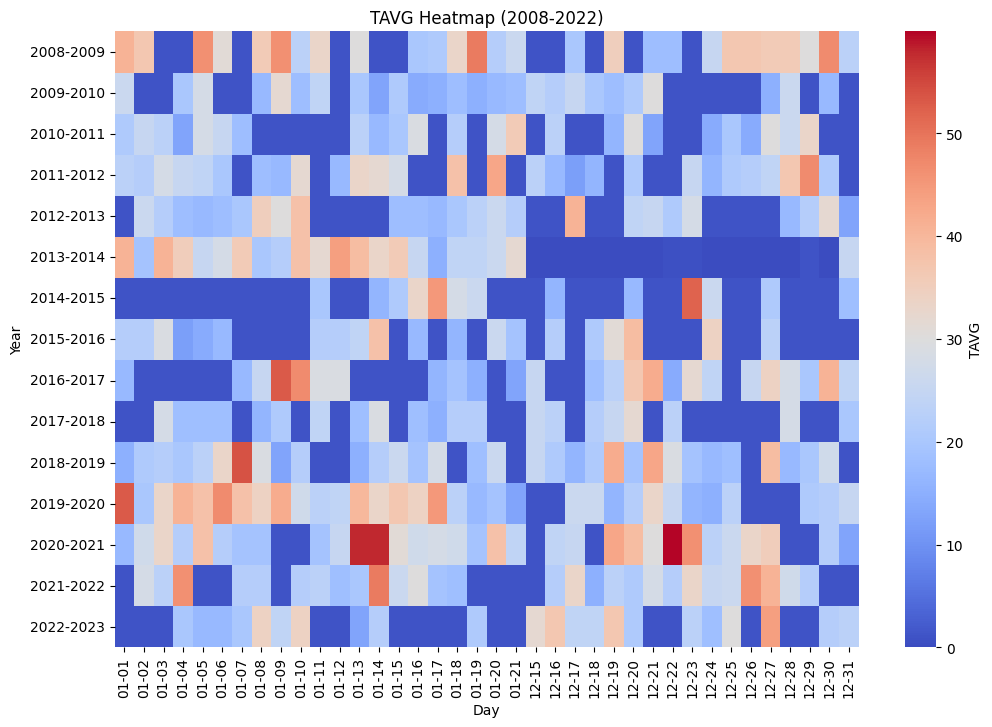

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file, explicitly parsing 'Date' column as datetime
weather_data = pd.read_csv('data/all_data_min.csv', parse_dates=['Date'], date_format=lambda x: pd.to_datetime(x, format='%m-%d'))

# Set the 'Date' column as the index
weather_data.set_index('Date', inplace=True)

# Transpose the DataFrame to have years as rows and days as columns
weather_data_transposed = weather_data.T

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(weather_data_transposed, cmap='coolwarm', cbar_kws={'label': 'TAVG'})
plt.title('TAVG Heatmap (2008-2022)')
plt.xlabel('Day')
plt.ylabel('Year')
plt.show()
